In [1]:
#---------------------------------------------------------------------------------
#                                 _             _      
#                                | |_  ___ _ __(_)__ _ 
#                                | ' \/ -_) '_ \ / _` |
#                                |_||_\___| .__/_\__,_|
#                                         |_|          
#
#---------------------------------------------------------------------------------
#
# Company: HEPIA // HES-SO
# Engineer: Varenne Hugo <hugo.varenne@master.hes-so.ch>
# 
# Project Name: Unleashing the Full Potential of 
#               High-Performance Cherenkov Telescopes
#               with Fully-Digital Solid-State Sensors Camera
#
# File: 4.0_visualize_predictions.ipynb
# Description: Notebook for visualizing predictions 
#
# Last update: 2025-09-17
#
#--------------------------------------------------------------------------------

In [2]:
# Imports
import hdf5plugin, h5py
import numpy as np
import sys
import os
import importlib
from ctlearn_manager import load_model_from_index
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob
import ctaplot
from sklearn import metrics

# Constant
RECO = "type"

In [3]:
# Custom tools
tools_path = os.path.join("../tools")
if tools_path not in sys.path:
    sys.path.append(tools_path)

import tools.CTLearnMgrConfig as CTLearnMgrConfig
importlib.reload(CTLearnMgrConfig)
import tools.CTLearnModelPredict as CTLearnModelPredict
importlib.reload(CTLearnModelPredict)

2025-09-26 10:16:14.943850: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 10:16:14.951271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-26 10:16:15.034695: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-26 10:16:15.034759: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-26 10:16:15.034910: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

<module 'tools.CTLearnModelPredict' from '/home/hugo/TM/ml/tools/CTLearnModelPredict.py'>

In [4]:
ctlearn_mgr_config = CTLearnMgrConfig.CTLearnMgrConfig()
ctlearn_mgr_config.load_config('../config/ctlearnmgr_config.yml')
ctlearn_mgr_config.print_config()

Base Directory: /home/hugo/TM
Simtel Relative Directory: data
Training Samples Directory: samples
Workspace Directory: ml
Simtel Path: /home/hugo/TM/data
Training Samples Path: /home/hugo/TM/data/samples
Workspace Path: /home/hugo/TM/ml
Model Index File: /home/hugo/TM/ml/ctlearn_models_index.h5


In [5]:
# Paths
prediction_directory = os.path.join(ctlearn_mgr_config.workspace_path, f"{RECO}_tel2_20deg_20", f"{RECO}_tel2_20deg_20_v0", "predict")
prediction_file =  os.path.join(prediction_directory, "proton_400_1300E3GeV_20_20deg_ATM52_206029.h5")

In [6]:
# Analyze predictions file

with h5py.File(prediction_file, "r") as f:
    print("Keys in file:", list(f.keys()))
    structure = False
    if structure: 
        def print_structure(name, obj):
            print(name, "->", type(obj))
        f.visititems(print_structure)  
    if RECO == "type":
        predictions = f["dl2/event/subarray/classification/CTLearn"]["event_id", "CTLearn_prediction", "CTLearn_is_valid", "CTLearn_goodness_of_fit"]
        print(predictions.dtype)
        predictions = predictions[()]
    elif RECO == "energy": 
        predictions = f["dl2/event/subarray/energy/CTLearn"]["event_id", "CTLearn_energy", "CTLearn_energy_uncert", "CTLearn_is_valid", "CTLearn_goodness_of_fit"]
        print(predictions.dtype)
        predictions = predictions[()]
    elif RECO == "skydirection":
        predictions = f["dl2/event/subarray/skydirection/CTLearn"]
    df = pd.DataFrame(predictions)

Keys in file: ['configuration', 'dl1', 'dl2', 'r1', 'simulation']
[('event_id', '<i8'), ('CTLearn_prediction', '<f8'), ('CTLearn_is_valid', 'u1'), ('CTLearn_goodness_of_fit', '<f8')]


In [9]:
df.head()
print(df["CTLearn_energy"].max())

KeyError: 'CTLearn_energy'

In [10]:
# filter for interesting results

df = df[df["CTLearn_is_valid"] == 1]
print(len(df))
print(df["CTLearn_prediction"].unique())
df.head()

426
[1. 0.]


,event_id,CTLearn_prediction,CTLearn_is_valid,CTLearn_goodness_of_fit
0,2313,1.0,1,NaN
1,7988,1.0,1,NaN
2,10370,1.0,1,NaN
3,13115,1.0,1,NaN
4,13119,1.0,1,NaN


In [11]:
# Extract GroundTruth

with h5py.File(prediction_file, "r") as f:
    print("Keys in file:", list(f.keys()))
    structure = False
    if structure: 
        def print_structure(name, obj):
            print(name, "->", type(obj))
        f.visititems(print_structure)
    groundtruth = f["simulation/event/subarray/shower"]
    print(groundtruth.dtype)
    groundtruth = groundtruth[:]
    groundtruth_df = pd.DataFrame(groundtruth)


Keys in file: ['configuration', 'dl1', 'dl2', 'r1', 'simulation']
[('obs_id', '<i4'), ('event_id', '<i8'), ('true_energy', '<f8'), ('true_alt', '<f8'), ('true_az', '<f8'), ('true_core_x', '<f8'), ('true_core_y', '<f8'), ('true_h_first_int', '<f8'), ('true_x_max', '<f8'), ('true_starting_grammage', '<f8'), ('true_shower_primary_id', '<i8')]


In [12]:
print(groundtruth_df["true_shower_primary_id"].unique())
print(groundtruth_df["true_energy"].max())
print(groundtruth_df["true_energy"].min())
groundtruth_df.head()

[101]
491.0465393066406
0.4101425111293793


,obs_id,event_id,true_energy,true_alt,true_az,true_core_x,true_core_y,true_h_first_int,true_x_max,true_starting_grammage,true_shower_primary_id
0,206029,362,2.101207,69.184024,186.172297,-145.209869,-101.332031,18852.935547,392.127655,0.0,101
1,206029,820,25.739122,65.754026,188.884619,-6.807944,-354.019958,24618.197266,498.927338,0.0,101
2,206029,844,25.739122,65.754026,188.884619,51.411842,-366.283020,24618.197266,498.927338,0.0,101
3,206029,2308,3.947646,65.675609,169.753820,188.584747,35.350826,19058.347656,299.575745,0.0,101
4,206029,2313,3.947646,65.675609,169.753820,209.836716,109.636581,19058.347656,299.575745,0.0,101


Keys in file: ['configuration', 'dl1', 'dl2', 'r1', 'simulation']
[('obs_id', '<i4'), ('hist_id', '<i8'), ('n_entries', '<i8'), ('bins_energy', '<f8', (121,)), ('bins_core_dist', '<f8', (201,)), ('histogram', '<f4', (120, 200))]


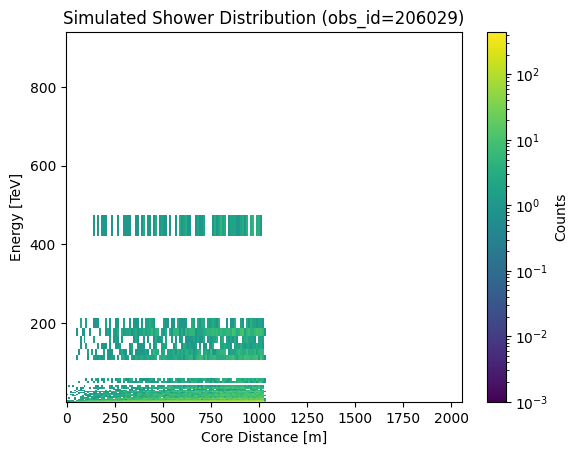

In [13]:
# Show distribution
with h5py.File(prediction_file, "r") as f:
    print("Keys in file:", list(f.keys()))

    distribution = f["simulation/service/shower_distribution"]
    print(distribution.dtype)
    histogram = distribution[0]

bins_energy = histogram["bins_energy"]
bins_core = histogram["bins_core_dist"]
hist = histogram["histogram"]

X, Y = np.meshgrid(bins_core[:-1], bins_energy[:-1])

plt.pcolormesh(X, Y, hist, shading='auto', norm=LogNorm(vmin=1e-3, vmax=hist.max()))
plt.xlabel("Core Distance [m]")
plt.ylabel("Energy [TeV]")
plt.title(f"Simulated Shower Distribution (obs_id={histogram['obs_id']})")
plt.colorbar(label="Counts")
plt.show()

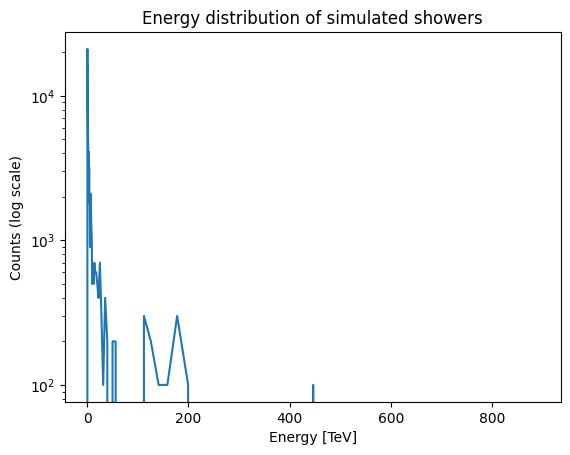

In [14]:
energy_proj = hist.sum(axis=1)
plt.plot(bins_energy[:-1], energy_proj)
plt.yscale("log")
plt.xlabel("Energy [TeV]")
plt.ylabel("Counts (log scale)")
plt.title("Energy distribution of simulated showers")
plt.show()

In [7]:
# remove model from file 

model_list = os.path.join(ctlearn_mgr_config.workspace_path, "ctlearn_models_index.h5")

with h5py.File(model_list, "a") as f:   # open in append mode
    # Example: remove an entire model version
    if "energy_tel2_20deg" in f:
        del f["energy_tel2_20deg"]
    print("Available keys:", list(f.keys()))
    

Available keys: ['energy_tel2_20deg', 'skydirection_tel2_20deg', 'type_tel2_20deg', 'type_tel2_20deg_20']


In [15]:
# Test pandas dataframe creation
path = os.path.join(ctlearn_mgr_config.workspace_path, "type_tel2_20deg", "type_tel2_20deg_v0", "predict", "gamma_200_800E3GeV_20_20deg_ATM52_100518.h5")
data = pd.HDFStore(path, 'r')


[]

In [27]:
# Search attribute

def find_in_h5(h5file, target):
    results = []

    def visitor(name, obj):
        if target in name:
            results.append(name)

        for attr in obj.attrs.keys():
            if target in attr:
                results.append(f"{name} (attribute: {attr})")

        if hasattr(obj, "dtype") and obj.dtype.names:
            for field in obj.dtype.names:
                if target in field:
                    results.append(f"{name} (field: {field})")

    with h5py.File(h5file, "r") as f:
        f.visititems(visitor)

    return results

In [35]:
results = find_in_h5(prediction_file, "type")
for r in results:
    print(r)

configuration/instrument/subarray/layout (field: type)
configuration/instrument/telescope/optics (field: size_type)
configuration/observation/scheduling_block (field: sb_type)
dl1/event/subarray/trigger (field: event_type)
r1/event/telescope/tel_001 (field: event_type)
r1/event/telescope/tel_002 (field: event_type)


In [17]:
# Extract Particular element

with h5py.File(prediction_file, "r") as f:
    print("Keys in file:", list(f.keys()))
    structure = False
    if structure: 
        def print_structure(name, obj):
            print(name, "->", type(obj))
        f.visititems(print_structure)
    feature = f["dl1/event/subarray/trigger"]['event_type']
    print(feature.dtype)
    feature = feature[:]
    feature_df = pd.DataFrame(feature)

Keys in file: ['configuration', 'dl1', 'dl2', 'r1', 'simulation']
int64


In [18]:
print(feature_df[0].unique())
feature_df.head()

[32]


,0
0,32
1,32
2,32
3,32
4,32


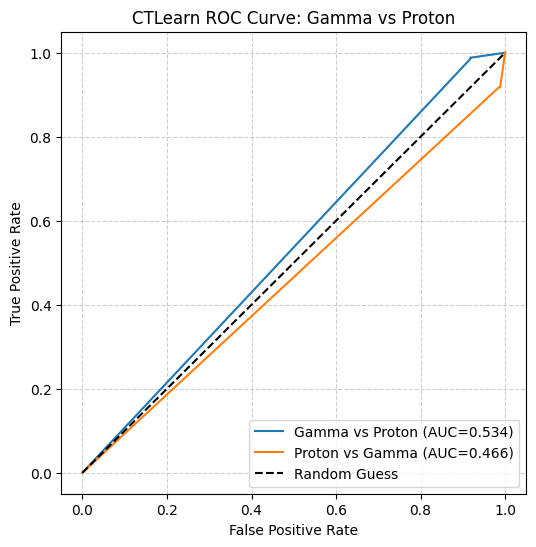

NameError: name 'auc_val' is not defined

In [20]:
# Evaluate Particle Type
result_folder = os.path.join(ctlearn_mgr_config.workspace_path, f"{RECO}_tel2_20deg_20", f"{RECO}_tel2_20deg_20_v0", "predict")
mapping = {0: 1, 101: 0}

proton_files = glob.glob(os.path.join(result_folder, f"proton*.h5"))
gamma_files = glob.glob(os.path.join(result_folder, f"gamma*.h5"))
df_all = pd.DataFrame()
    
for fileset in [proton_files, gamma_files]:
        for file in fileset:
            with h5py.File(file, 'r') as data:
                # Get DL2 predictions
                if 'dl2/event/subarray/classification/CTLearn' in data:
                    pred_ds = data['dl2/event/subarray/classification/CTLearn']['event_id', 'CTLearn_prediction', 'CTLearn_is_valid', 'CTLearn_goodness_of_fit']
                    pred_ds = pd.DataFrame(pred_ds)
                    pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]
                    # Ground truth
                    ground_truth = data["simulation/event/subarray/shower"][:]
                    ground_truth_df = pd.DataFrame(ground_truth, columns=["event_id", "true_shower_primary_id"])
                    df = pd.merge(pred_ds, ground_truth_df, on="event_id", how="inner")
                    
                    df["particle_id"] = df["true_shower_primary_id"].map(mapping)
                    df_all = pd.concat([df_all, df], ignore_index=True)
# ROC & AUC
fpr_gamma, tpr_gamma, thresholds_gamma = metrics.roc_curve(df_all["particle_id"], df_all['CTLearn_prediction'], pos_label=1)
auc_gamma = metrics.auc(fpr_gamma, tpr_gamma)

fpr_proton, tpr_proton, thresholds_proton = metrics.roc_curve(df_all["particle_id"], df_all['CTLearn_prediction'], pos_label=0)
auc_proton = metrics.auc(fpr_proton, tpr_proton)


# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr_gamma, tpr_gamma, label=f"Gamma vs Proton (AUC={auc_gamma:.3f})")
plt.plot(fpr_proton, tpr_proton, label=f"Proton vs Gamma (AUC={auc_proton:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CTLearn ROC Curve: Gamma vs Proton")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

print(f"AUC = {auc_val:.3f}")

In [16]:
# Evaluate Particle Type
result_folder = os.path.join(ctlearn_mgr_config.workspace_path, f"{RECO}_tel2_20deg", f"{RECO}_tel2_20deg_v0", "predict")


proton_files = glob.glob(os.path.join(result_folder, f"proton*.h5"))
gamma_files = glob.glob(os.path.join(result_folder, f"gamma*.h5"))
df_all = pd.DataFrame()
for fileset in [proton_files, gamma_files]:
        for file in fileset:
            with h5py.File(file, 'r') as data:
                # Get DL2 predictions
                if 'dl2/event/subarray/energy/CTLearn' in data:
                    pred_ds = data['dl2/event/subarray/energy/CTLearn']['event_id', 'CTLearn_energy', 'CTLearn_is_valid', 'CTLearn_energy_uncert']
                    pred_ds = pd.DataFrame(pred_ds)
                    pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]
                    # Ground truth
                    ground_truth = data["simulation/event/subarray/shower"][:]
                    ground_truth_df = pd.DataFrame(ground_truth, columns=["event_id", "true_energy", "true_shower_primary_id"])
                    df = pd.merge(pred_ds, ground_truth_df, on="event_id", how="inner")
                    df_all = pd.concat([df_all, df], ignore_index=True)


protons_df = df_all[df_all["true_shower_primary_id"] == 101]
gammas_df = df_all[df_all["true_shower_primary_id"] == 0]

plt.figure(figsize=(7,7))

# Scatter plot: predicted vs true
plt.scatter(gammas_df["true_energy"], gammas_df["CTLearn_energy"], 
            alpha=0.4, label="Gamma", s=20, color="blue")
plt.scatter(protons_df["true_energy"], protons_df["CTLearn_energy"], 
            alpha=0.4, label="Proton", s=20, color="red")

lims = [min(df["true_energy"].min(), df["CTLearn_energy"].min()), 
        max(df["true_energy"].max(), df["CTLearn_energy"].max())]
plt.plot(lims, lims, 'k--', lw=2, label="Perfect prediction")

plt.xlabel("True Energy [TeV]")
plt.ylabel("Predicted Energy [TeV]")
plt.legend()
plt.title("Energy Regression: CTLearn vs Ground Truth")
plt.grid(alpha=0.3)
plt.show()

KeyError: 'true_shower_primary_id'

In [17]:
df_all.head()

,event_id,CTLearn_energy,CTLearn_is_valid,CTLearn_energy_uncert,true_energy,true_shower_primary_id
0,2313,6.482418e-10,1,0.000000e+00,3.947646,101
1,7988,3.299672e-09,1,0.000000e+00,3.216969,101
2,10370,1.930689e-10,1,0.000000e+00,1.178466,101
3,13115,1.325058e-09,1,9.728766e-10,7.189730,101
4,13119,6.407299e-10,1,0.000000e+00,7.189730,101
